In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

%matplotlib inline
pd.set_option('display.max_columns', 100)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def one_hot(lst, num_class=4) :
    return np.eye(num_class)[lst]

In [3]:
def making_data(csv) :
    activity = pd.read_csv(csv).drop("Unnamed: 0", axis=1)
    label = activity[["acc_id", "label"]]
    
    activity = activity[activity["label"] != "empty"]
    activity = activity.drop("label", axis=1)
    label = label[label["label"] != "empty"]
    
    activity = activity.sort_values(["acc_id","wk"])[['acc_id', 'wk', 'cnt_clear_bam', 'cnt_clear_inzone_light','cnt_clear_inzone_normal', 
                                                  'cnt_clear_inzone_skilled', 'cnt_clear_inzone_solo', 'cnt_clear_raid', 'cnt_clear_raid_light',
                                                  'cnt_dt', 'cnt_enter_bam', 'cnt_enter_inzone_light', 'cnt_enter_inzone_normal', 
                                                  'cnt_enter_inzone_skilled', 'cnt_enter_inzone_solo', 'cnt_enter_raid', 'cnt_enter_raid_light',
                                                  'cnt_use_buffitem', 'district_chat', 'duel_cnt', 'duel_win', 'faction_chat', 'game_combat_time', 
                                                  'gathering_cnt', 'get_money','guild_chat', 'item_hongmun', 'making_cnt', 'normal_chat', 
                                                  'npc_exp', 'npc_hongmun', 'party_chat', 'partybattle_cnt', 'partybattle_win', 'play_time', 
                                                  'quest_exp', 'quest_hongmun', 'whisper_chat','first_week', 'payment_amount']]
    label = label.sort_values("acc_id")
    
    label_lst = sorted(list(set([tuple(x) for x in label.values])))
    label = pd.DataFrame(label_lst, columns = ["acc_id", "label"])
    
    activity1 = activity[activity["wk"]==1].drop(["acc_id", "wk"], axis=1)
    activity2 = activity[activity["wk"]==2].drop(["acc_id", "wk"], axis=1)
    activity3 = activity[activity["wk"]==3].drop(["acc_id", "wk"], axis=1)
    activity4 = activity[activity["wk"]==4].drop(["acc_id", "wk"], axis=1)
    activity5 = activity[activity["wk"]==5].drop(["acc_id", "wk"], axis=1)
    activity6 = activity[activity["wk"]==6].drop(["acc_id", "wk"], axis=1)
    activity7 = activity[activity["wk"]==7].drop(["acc_id", "wk"], axis=1)
    activity8 = activity[activity["wk"]==8].drop(["acc_id", "wk"], axis=1)
    
    activity = np.concatenate([activity1.values, activity2.values, activity3.values, activity4.values,
                               activity5.values, activity6.values, activity7.values, activity8.values], axis=1)
    
    label_dic = {"week":0 , "month" :1, "2month":2, "retained":3}

    label2 = label.sort_values(by="acc_id")
    label2["label"] = label2["label"].map(lambda x : label_dic[x])
    
    total_lst = activity
    label_dic = label2.label.tolist()
    total_label = one_hot(label_dic)
    
    return total_lst, total_label

<br></br><br></br><br></br>

In [4]:
total_lst, total_label = making_data("OnlyExpanded.csv")

In [5]:
idx1 = len(total_lst)//5 *4

training_lst = np.array(total_lst[:idx1])
valid_lst = np.array(total_lst[idx1:])

training_label = np.array(total_label[:idx1])
valid_label = np.array(total_label[idx1:])

In [6]:
print(np.array(total_lst).shape)
print(np.array(total_label).shape)

(100000, 304)
(100000, 4)


<br></br><br></br><br></br>

# Model

In [7]:
class MLP() :
    def __init__(self, sess, name):
        self.sess = sess
        self.name = name
        
    def day_MLP(self, X_input) :
        layer = tf.layers.dense(X_input, self.emb_dim)
        
        for idx in range(self.num_layer//3+1) :
            norm1 = tf.contrib.layers.layer_norm(layer)
            relu1 = tf.nn.leaky_relu(norm1)
            layer1 = tf.layers.dense(relu1, self.emb_dim*2)
                
            norm2 = tf.contrib.layers.layer_norm(layer1)
            relu2 = tf.nn.leaky_relu(norm2)
            layer2 = tf.layers.dense(relu2, self.emb_dim)
            
            layer = layer2 + layer
                
        summary_layer = tf.layers.dense(layer, self.emb_dim//2)
        return summary_layer
    
    def build(self, batch_size, input_dim, emb_dim, output_dim, num_layer, num_unit, activation) :
        with tf.variable_scope(self.name) :
            
            ## Setting ##
            # input  : ? x input_length x input_dim
            self.X = tf.placeholder(tf.float32, [None, input_dim])
            self.Y = tf.placeholder(tf.float32, [None, output_dim])
            self.learning_rate =  tf.placeholder(tf.float32)
            self.training = tf.placeholder(tf.bool)
            
            self.batch_size = batch_size
            self.day_dim = input_dim//8
            self.emb_dim = emb_dim
            self.output_dim = output_dim
            self.num_layer = num_layer
            self.num_unit = num_unit
            self.activation = activation
            #############
            
            
            ## MLP ##
            day1 = self.day_MLP(self.X[:,:self.day_dim])
            day2 = self.day_MLP(self.X[:,self.day_dim : self.day_dim*2])
            day3 = self.day_MLP(self.X[:,self.day_dim*2 : self.day_dim*3])
            day4 = self.day_MLP(self.X[:,self.day_dim*3 : self.day_dim*4])
            day5 = self.day_MLP(self.X[:,self.day_dim*4 : self.day_dim*5])
            day6 = self.day_MLP(self.X[:,self.day_dim*5 : self.day_dim*6])
            day7 = self.day_MLP(self.X[:,self.day_dim*6 : self.day_dim*7])
            day8 = self.day_MLP(self.X[:,self.day_dim*7 :])
            
            day_total = tf.concat([day1,day2,day3,day4,day5,day6,day7,day8], axis=1)
            day_norm = tf.contrib.layers.layer_norm(day_total)
            day_relu = tf.nn.leaky_relu(day_norm)
            layer = tf.layers.dense(day_relu, self.num_unit)
            
            for idx in range(self.num_layer//3*2) :
                norm = tf.contrib.layers.layer_norm(layer)
                layer = tf.layers.dense(norm, self.num_unit, activation=self.activation)
                dropout = tf.layers.dropout(layer, training=self.training)
                
            layer = tf.layers.dense(layer, self.output_dim)
            #########################
            
            
            ## Classifier ##
            self.logit = layer
            self.softmax = tf.nn.softmax(self.logit)
            self.softmax_logit = tf.nn.softmax_cross_entropy_with_logits(logits=self.logit, labels=self.Y)
            ################
            
            
            ## Learning ##
            self.cost =  tf.reduce_mean(self.softmax_logit)

            update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope=self.name)
            with tf.control_dependencies(update_ops):
                self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)
            
            self.prediction = tf.equal(tf.argmax(self.logit, 1), tf.argmax(self.Y, 1))     
            self.accuracy = tf.reduce_mean(tf.cast(self.prediction, tf.float32))    
            ##############
        
        
    def train(self, X_input, Y_input, learning_rate, training=True):
        feed_dict = {self.X: X_input, self.Y: Y_input, self.learning_rate: learning_rate, self.training: training}
        _, cost = self.sess.run([self.optimizer, self.cost], feed_dict=feed_dict)
        
        return _, cost
    
    def predict(self, X_input, training=False):
        feed_dict = {self.X: X_input, self.training: training}
        result = self.sess.run([self.logit], feed_dict=feed_dict)
            
        return result
    
    def evaluate(self, X_input, Y_input):
        size = X_input.shape[0]
            
        total_loss = 0
        total_acc = 0
            
        for idx in range(0, size, self.batch_size):
            X_batch = X_input[idx:idx + batch_size]
            Y_batch = Y_input[idx:idx + batch_size]
            feed_dict = {self.X: X_batch, self.Y: Y_batch, self.training: False}
                
            loss = self.cost
            accuracy = self.accuracy
                
            step_loss, step_acc = self.sess.run([loss, accuracy], feed_dict=feed_dict)
                
            total_loss += step_loss * X_batch.shape[0]
            total_acc += step_acc * X_batch.shape[0]
            
        total_loss /= size
        total_acc /= size
            
        return total_loss, total_acc

In [8]:
tf.reset_default_graph() 

<br></br><br></br><br></br> 

In [9]:
learning_rate1 = 0.02
learning_rate2 = 0.01
learning_rate3 = 0.005
learning_rate4 = 0.001

total_epoch = 100
batch_size = 500
input_dim = np.array(total_lst).shape[1]

In [10]:
idx = 0
model_lst = []

for num_layer in [4,6] :
    for num_unit in [256] :
        for activation in [None, tf.nn.relu] :
            for emb_dim in [38,64] :
                print(idx)
                sess = tf.Session()
                model = MLP(sess, "model{}".format(idx))
                model.build(batch_size, input_dim, emb_dim, 4, num_layer, num_unit, activation)
                sess.run(tf.global_variables_initializer())
            
                model_lst.append(model)
                idx+=1
            
tl_ta_vl_va_lst = [[[],[],[],[]]]*len(model_lst)
print("Ready!")

0
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

1
2
3
4
5
6
7
Ready!


In [11]:
print('Learning Started!')
print("")

# train my model
for epoch in range(total_epoch):
    avg_cost = [0]*len(model_lst)
    total_batch = int(len(training_lst) / batch_size)
    idx = 0
    
    if epoch == 0 :
        learning_rate = learning_rate1
    elif epoch == 10 :
        learning_rate = learning_rate2
    elif epoch == 20 :
        learning_rate = learning_rate3
    elif epoch == 80 :
        learning_rate = learning_rate4

    for i in range(total_batch):
        batch_xs, batch_ys = training_lst[idx:idx+batch_size],training_label[idx:idx+batch_size]
        
        for model_num, model in enumerate(model_lst) :
            _, c = model.train(batch_xs, batch_ys, learning_rate)
            avg_cost[model_num] += c / total_batch
        
        idx += batch_size
        if i%10 == 0 :
            print("log :", i)
            
    #train/valid cost & acc
    print("***epoch*** : ", epoch)
    for model_num, model in enumerate(model_lst) :
        train_cost, train_acc = model.evaluate(training_lst, training_label)
        valid_cost, valid_acc = model.evaluate(valid_lst, valid_label)

        tl_ta_vl_va_lst[model_num][0].append(train_cost)
        tl_ta_vl_va_lst[model_num][1].append(train_acc)
        tl_ta_vl_va_lst[model_num][2].append(valid_cost)
        tl_ta_vl_va_lst[model_num][3].append(valid_acc)

        print("-- train {:.5f}({:.1f}%), valid{:.5f}({:.1f}%)".format(train_cost, train_acc*100, valid_cost, valid_acc*100))
    
    for model in model_lst :
        print('Accuracy:', model.evaluate(valid_lst, valid_label)[1])
    print(" ")

print("")
print('Learning Finished!')

Learning Started!

log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  0
-- train 1.05300(55.7%), valid1.04856(55.6%)
-- train 1.26114(40.4%), valid1.26171(40.7%)
-- train 1.03424(53.6%), valid1.02874(53.9%)
-- train 1.11930(50.6%), valid1.11530(50.9%)
-- train 1.38279(35.1%), valid1.38292(35.0%)
-- train 1.38391(35.3%), valid1.38364(35.4%)
-- train 1.38637(24.9%), valid1.38634(25.3%)
-- train 1.38632(25.0%), valid1.38632(25.1%)
Accuracy: 0.556300000846386
Accuracy: 0.40679999962449076
Accuracy: 0.5394999995827675
Accuracy: 0.5091999970376492
Accuracy: 0.3501000002026558
Accuracy: 0.3541500002145767
Accuracy: 0.25285000056028367
Accuracy: 0.2507000010460615
 
log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  1
-- train 0.92168(59.6%), valid0.91667(59.7%)
-- train 

Accuracy: 0.6708499982953071
Accuracy: 0.6704499945044518
Accuracy: 0.6199500024318695
Accuracy: 0.664800001680851
Accuracy: 0.25285000056028367
Accuracy: 0.25285000056028367
 
log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  11
-- train 0.74662(67.4%), valid0.75581(67.2%)
-- train 0.75236(66.9%), valid0.76077(66.9%)
-- train 0.73715(67.3%), valid0.74219(67.4%)
-- train 0.73921(67.3%), valid0.74485(67.2%)
-- train 0.86929(63.1%), valid0.87632(63.2%)
-- train 0.75647(66.9%), valid0.75949(66.9%)
-- train 1.38623(24.9%), valid1.38608(25.3%)
-- train 1.38638(24.9%), valid1.38629(25.3%)
Accuracy: 0.6724500000476837
Accuracy: 0.6687000021338463
Accuracy: 0.6741499975323677
Accuracy: 0.6722499996423721
Accuracy: 0.6315999984741211
Accuracy: 0.6693499967455864
Accuracy: 0.25285000056028367
Accuracy: 0.25285000056028367
 
log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 6

-- train 0.71875(68.1%), valid0.73128(68.0%)
-- train 1.38619(24.9%), valid1.38611(25.3%)
-- train 1.38635(24.9%), valid1.38631(25.3%)
Accuracy: 0.6808999970555305
Accuracy: 0.681400004029274
Accuracy: 0.6846999958157539
Accuracy: 0.6830999985337257
Accuracy: 0.6754999965429306
Accuracy: 0.6800499945878983
Accuracy: 0.25285000056028367
Accuracy: 0.25285000056028367
 
log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  22
-- train 0.71536(68.5%), valid0.73138(68.2%)
-- train 0.71026(68.5%), valid0.72327(68.2%)
-- train 0.69260(68.8%), valid0.71122(68.5%)
-- train 0.70173(68.5%), valid0.71329(68.2%)
-- train 0.72247(68.4%), valid0.73391(68.1%)
-- train 0.71627(68.0%), valid0.73040(67.9%)
-- train 1.38619(24.9%), valid1.38610(25.3%)
-- train 1.38635(24.9%), valid1.38631(25.3%)
Accuracy: 0.6816999986767769
Accuracy: 0.6816499978303909
Accuracy: 0.6848999992012977
Accuracy: 0.6821

-- train 0.69558(69.1%), valid0.71465(68.7%)
-- train 0.67762(69.8%), valid0.70590(69.0%)
-- train 0.68336(69.1%), valid0.70509(68.6%)
-- train 0.70338(68.8%), valid0.72797(68.3%)
-- train 0.70219(68.6%), valid0.72403(68.3%)
-- train 1.38620(24.9%), valid1.38610(25.3%)
-- train 1.38635(24.9%), valid1.38631(25.3%)
Accuracy: 0.6813499957323075
Accuracy: 0.6866499945521355
Accuracy: 0.6902999922633171
Accuracy: 0.6856000006198884
Accuracy: 0.6832000032067299
Accuracy: 0.683249993622303
Accuracy: 0.25285000056028367
Accuracy: 0.25285000056028367
 
log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  33
-- train 0.69824(68.9%), valid0.72337(68.3%)
-- train 0.69577(69.0%), valid0.71617(68.6%)
-- train 0.67660(69.8%), valid0.70464(69.2%)
-- train 0.69361(69.2%), valid0.71382(68.5%)
-- train 0.70282(69.1%), valid0.72700(68.6%)
-- train 0.69908(68.8%), valid0.72328(68.4%)
-- train 1.38

log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  43
-- train 0.68561(69.4%), valid0.72168(68.4%)
-- train 0.68155(69.7%), valid0.71408(68.9%)
-- train 0.65965(70.5%), valid0.69670(69.5%)
-- train 0.66683(70.0%), valid0.69979(69.3%)
-- train 0.68926(69.5%), valid0.71970(68.8%)
-- train 0.69148(69.3%), valid0.72514(68.8%)
-- train 1.38620(24.9%), valid1.38610(25.3%)
-- train 1.38635(24.9%), valid1.38631(25.3%)
Accuracy: 0.6840499982237815
Accuracy: 0.6885999977588654
Accuracy: 0.6946499973535538
Accuracy: 0.6934499993920327
Accuracy: 0.6881499961018562
Accuracy: 0.6878000035881996
Accuracy: 0.25285000056028367
Accuracy: 0.25285000056028367
 
log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  44
-- train 0.68423(69.2%), valid0.72212(68.2%)
-- train 0.68086(69.7%), valid0.71398(68.7%)
-- tra

Accuracy: 0.6969499975442887
Accuracy: 0.6879999950528145
Accuracy: 0.6901500001549721
Accuracy: 0.25285000056028367
Accuracy: 0.25285000056028367
 
log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  54
-- train 0.66662(70.0%), valid0.72314(68.6%)
-- train 0.67501(69.9%), valid0.71267(68.8%)
-- train 0.64716(71.0%), valid0.69868(69.5%)
-- train 0.64794(71.1%), valid0.69646(70.0%)
-- train 0.67635(69.8%), valid0.72197(68.9%)
-- train 0.67300(69.8%), valid0.72121(69.0%)
-- train 1.38620(24.9%), valid1.38610(25.3%)
-- train 1.38635(24.9%), valid1.38631(25.3%)
Accuracy: 0.6863000005483627
Accuracy: 0.6875499993562698
Accuracy: 0.6948499977588654
Accuracy: 0.6999500051140786
Accuracy: 0.6885999962687492
Accuracy: 0.6899000003933906
Accuracy: 0.25285000056028367
Accuracy: 0.25285000056028367
 
log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90

-- train 1.38620(24.9%), valid1.38610(25.3%)
-- train 1.38635(24.9%), valid1.38631(25.3%)
Accuracy: 0.6850999966263771
Accuracy: 0.6876499965786934
Accuracy: 0.6949999958276749
Accuracy: 0.6958000004291535
Accuracy: 0.6910499975085258
Accuracy: 0.6870499983429909
Accuracy: 0.25285000056028367
Accuracy: 0.25285000056028367
 
log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  65
-- train 0.65305(70.4%), valid0.72895(68.6%)
-- train 0.66683(70.2%), valid0.72749(68.7%)
-- train 0.63438(71.6%), valid0.73612(69.5%)
-- train 0.63995(71.5%), valid0.70843(70.0%)
-- train 0.66429(70.2%), valid0.72447(69.0%)
-- train 0.67235(69.7%), valid0.72771(68.7%)
-- train 1.38620(24.9%), valid1.38610(25.3%)
-- train 1.38635(24.9%), valid1.38631(25.3%)
Accuracy: 0.6858999967575073
Accuracy: 0.687399996817112
Accuracy: 0.6949499979615211
Accuracy: 0.6998999997973442
Accuracy: 0.6901999980211257
Acc

-- train 0.63041(71.8%), valid0.72411(69.9%)
-- train 0.66282(70.5%), valid0.73074(68.8%)
-- train 0.68166(69.7%), valid0.76452(68.7%)
-- train 1.38620(24.9%), valid1.38610(25.3%)
-- train 1.38635(24.9%), valid1.38631(25.3%)
Accuracy: 0.6839499950408936
Accuracy: 0.6863999962806702
Accuracy: 0.6912499979138375
Accuracy: 0.6994499996304512
Accuracy: 0.6880999982357026
Accuracy: 0.6871000051498413
Accuracy: 0.25285000056028367
Accuracy: 0.25285000056028367
 
log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  76
-- train 0.65224(70.7%), valid0.73410(68.6%)
-- train 0.65628(70.6%), valid0.73460(69.0%)
-- train 0.63358(71.8%), valid0.77716(69.3%)
-- train 0.63373(71.6%), valid0.72103(69.7%)
-- train 0.67592(70.1%), valid0.75314(68.8%)
-- train 0.69238(69.5%), valid0.78068(68.3%)
-- train 1.38620(24.9%), valid1.38610(25.3%)
-- train 1.38635(24.9%), valid1.38631(25.3%)
Accuracy: 0.

log : 130
log : 140
log : 150
***epoch*** :  86
-- train 0.60934(72.2%), valid0.76354(69.3%)
-- train 0.61541(72.0%), valid0.76553(69.5%)
-- train 0.56337(74.3%), valid0.81275(70.1%)
-- train 0.57005(74.0%), valid0.74390(70.3%)
-- train 0.62510(71.5%), valid0.75612(69.3%)
-- train 0.63224(71.3%), valid0.73725(69.4%)
-- train 1.38614(25.1%), valid1.38612(24.7%)
-- train 1.38629(25.1%), valid1.38633(24.7%)
Accuracy: 0.6933499991893768
Accuracy: 0.6954999968409539
Accuracy: 0.700799998641014
Accuracy: 0.7025999993085861
Accuracy: 0.6925500005483627
Accuracy: 0.6938999965786934
Accuracy: 0.24695000126957894
Accuracy: 0.24680000245571138
 
log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  87
-- train 0.60795(72.3%), valid0.76622(69.3%)
-- train 0.61397(72.0%), valid0.76832(69.5%)
-- train 0.56074(74.4%), valid0.81630(70.2%)
-- train 0.56714(74.1%), valid0.74496(70.3%)
-- train 0

Accuracy: 0.24695000126957894
Accuracy: 0.24680000245571138
 
log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  97
-- train 0.59780(72.6%), valid0.79629(69.2%)
-- train 0.60276(72.5%), valid0.78048(69.5%)
-- train 0.54405(75.3%), valid0.90393(70.2%)
-- train 0.55421(74.8%), valid0.79574(70.1%)
-- train 0.62910(71.4%), valid0.81106(68.7%)
-- train 0.62772(71.4%), valid0.76152(69.2%)
-- train 1.38614(25.1%), valid1.38612(24.7%)
-- train 1.38629(25.1%), valid1.38633(24.7%)
Accuracy: 0.6921499982476235
Accuracy: 0.6948499977588654
Accuracy: 0.7022999972105026
Accuracy: 0.7010999992489815
Accuracy: 0.6867999970912934
Accuracy: 0.6921499967575073
Accuracy: 0.24695000126957894
Accuracy: 0.24680000245571138
 
log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  98
-- train

 <br></br><br></br><br></br> 

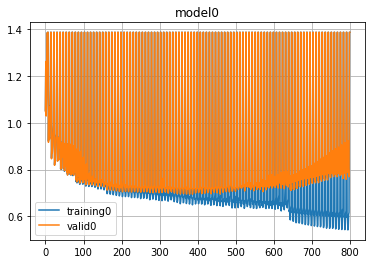

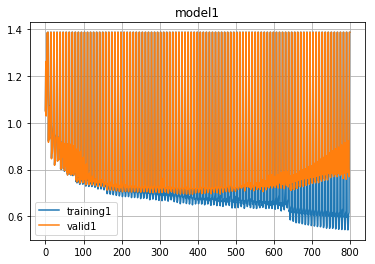

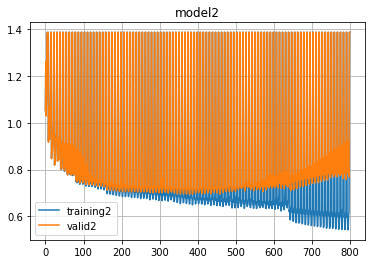

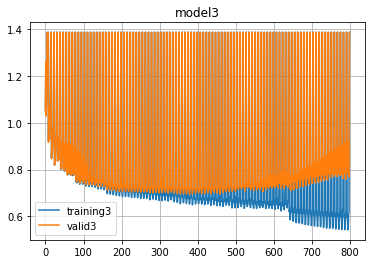

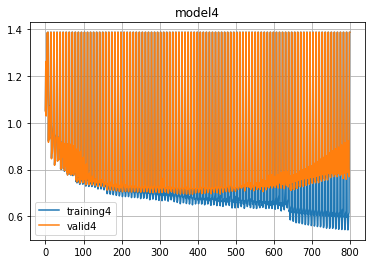

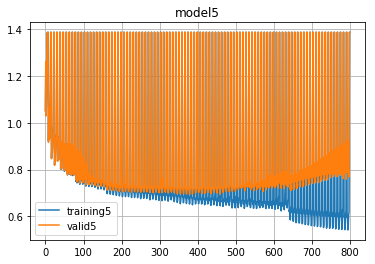

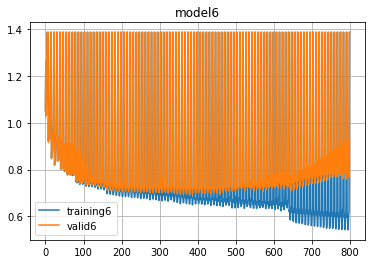

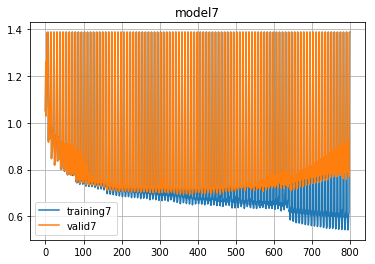

In [12]:
for idx in range(len(model_lst)) :
    plt.plot(tl_ta_vl_va_lst[idx][0], label='training'+str(idx))
    plt.plot(tl_ta_vl_va_lst[idx][2], label='valid'+str(idx))
    plt.title("model"+str(idx))
    plt.grid("on")
    plt.legend()
    plt.show()

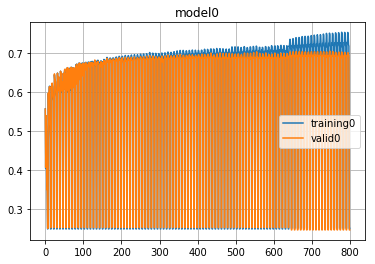

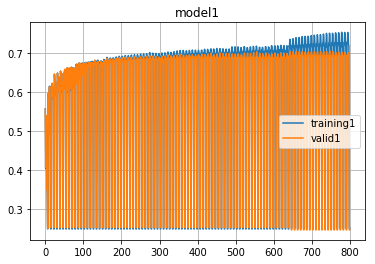

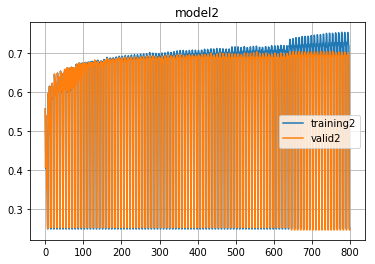

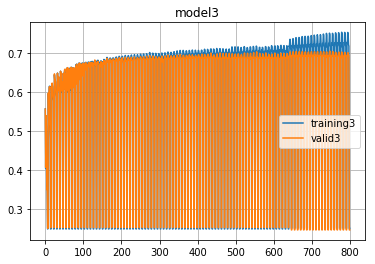

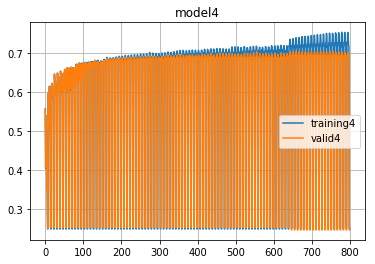

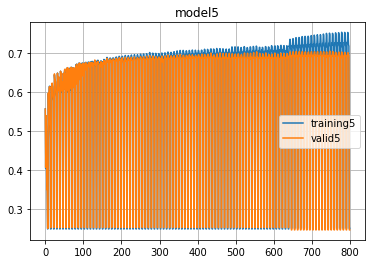

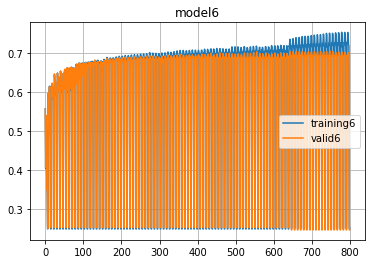

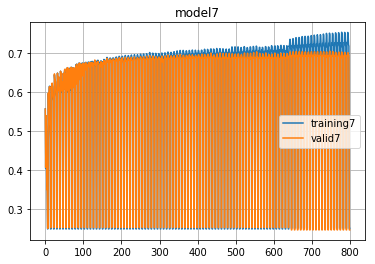

In [13]:
for idx in range(len(model_lst)) :
    plt.plot(tl_ta_vl_va_lst[idx][1], label='training'+str(idx))
    plt.plot(tl_ta_vl_va_lst[idx][3], label='valid'+str(idx))
    plt.title("model"+str(idx))
    plt.grid("on")
    plt.legend()
    plt.show()

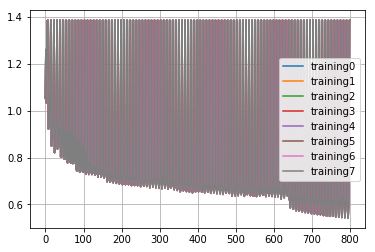

In [14]:
for idx in range(len(model_lst)) :
    plt.plot(tl_ta_vl_va_lst[idx][0], label='training'+str(idx))
    
plt.grid("on")
plt.legend()
plt.show()

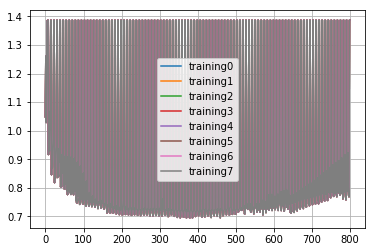

In [15]:
for idx in range(len(model_lst)) :
    plt.plot(tl_ta_vl_va_lst[idx][2], label='training'+str(idx))
    
plt.grid("on")
plt.legend()
plt.show()

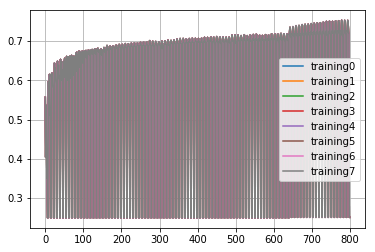

In [16]:
for idx in range(len(model_lst)) :
    plt.plot(tl_ta_vl_va_lst[idx][1], label='training'+str(idx))
    
plt.grid("on")
plt.legend()
plt.show()

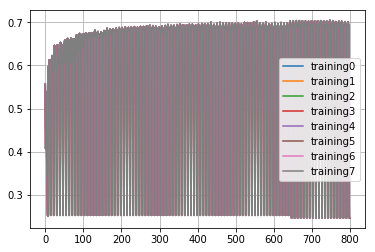

In [17]:
for idx in range(len(model_lst)) :
    plt.plot(tl_ta_vl_va_lst[idx][3], label='training'+str(idx))
    
plt.grid("on")
plt.legend()
plt.show()

<br></br><br></br><br></br>  

In [ ]:
#tf.reset_default_graph() 

In [364]:
saver = tf.train.Saver()

for idx, model in enumerate(model_lst) :
    saver.save(model.sess, './model/MLP_default_separated_model_{}'.format(idx))

print("Saved!")

'./advanced_RNN/original_user_vector/original'

<br></br><br></br><br></br>

# Test

In [45]:
def making_data(csv) :
    activity = pd.read_csv(csv).drop("Unnamed: 0", axis=1)
    
    activity = activity[activity["label"] == "empty"]
    activity = activity.drop("label", axis=1)
    
    activity = activity.sort_values(["acc_id","wk"])[['acc_id', 'wk', 'cnt_clear_bam', 'cnt_clear_inzone_light','cnt_clear_inzone_normal', 
                                                  'cnt_clear_inzone_skilled', 'cnt_clear_inzone_solo', 'cnt_clear_raid', 'cnt_clear_raid_light',
                                                  'cnt_dt', 'cnt_enter_bam', 'cnt_enter_inzone_light', 'cnt_enter_inzone_normal', 
                                                  'cnt_enter_inzone_skilled', 'cnt_enter_inzone_solo', 'cnt_enter_raid', 'cnt_enter_raid_light',
                                                  'cnt_use_buffitem', 'district_chat', 'duel_cnt', 'duel_win', 'faction_chat', 'game_combat_time', 
                                                  'gathering_cnt', 'get_money','guild_chat', 'item_hongmun', 'making_cnt', 'normal_chat', 
                                                  'npc_exp', 'npc_hongmun', 'party_chat', 'partybattle_cnt', 'partybattle_win', 'play_time', 
                                                  'quest_exp', 'quest_hongmun', 'whisper_chat','first_week', 'payment_amount']]
    
    activity1 = activity[activity["wk"]==1].drop(["acc_id", "wk"], axis=1)
    activity2 = activity[activity["wk"]==2].drop(["acc_id", "wk"], axis=1)
    activity3 = activity[activity["wk"]==3].drop(["acc_id", "wk"], axis=1)
    activity4 = activity[activity["wk"]==4].drop(["acc_id", "wk"], axis=1)
    activity5 = activity[activity["wk"]==5].drop(["acc_id", "wk"], axis=1)
    activity6 = activity[activity["wk"]==6].drop(["acc_id", "wk"], axis=1)
    activity7 = activity[activity["wk"]==7].drop(["acc_id", "wk"], axis=1)
    activity8 = activity[activity["wk"]==8].drop(["acc_id", "wk"], axis=1)
    
    label = activity["acc_id"].values
    activity = np.concatenate([activity1.values, activity2.values, activity3.values, activity4.values,
                               activity5.values, activity6.values, activity7.values, activity8.values], axis=1)

    total_lst = activity
    return total_lst, label

In [50]:
test_data, test_acc_id = making_data("OnlyExpanded.csv")

In [51]:
print(test_data.shape)

(40000, 304)


<br></br><br></br><br></br> 

# Predict

In [ ]:
result = []
for model in model_lst :
    result.append(np.argmax(model.predict(test_data), axis=2)) 
    
result = list(map(lambda x : x.tolist()[0], result))
for r_lst in result :
    print("week: {}, month: {}, 2month: {}, retained: {}".format(r_lst.count(0), r_lst.count(1), r_lst.count(2), r_lst.count(3)))

In [ ]:
label_df = pd.DataFrame(sorted(list(set(list(test_acc_id))))).rename(columns = {0 : "acc_id"})
result_df = pd.DataFrame(result).T


In [ ]:
result_df2 = pd.concat([label_df, result_df], axis=1)
result_df2.head()